In [1]:
__nbid__ = '0050'
__author__ = 'Knut Olsen <knut.olsen@noirlab.edu>'
__version__ = '20240607' # yyyymmdd
__datasets__ = ['stripe82', 'nsc_dr2', 'decaps_dr1', 'des_dr1', 'des_dr2', 'des_sva1', 'gogreen_dr1', 'ls_dr8', 'ls_dr9', 'smash_dr1', 'smash_dr2', 'splus_dr1', 'splus_edr']
__keywords__ = ['image cutout', 'SIA', 'tutorial']

# How to use the Simple Image Access (SIA) Service to make image cutouts

*Knut Olsen & Astro Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [What is the Simple Image Access service?](#chapter1)
* [Example usage](#chapter2)
* [Making the process easier with functions](#chapter3)

<a class="anchor" id="goals"></a>
# Goals
Show how to use the Simple Image Access (SIA) Service API to make image cutouts.

# Summary
In this notebook, we describe and demonstrate the SIA Service API and use it to make an example set of image cutouts.  We list all of the available image collections available through SIA services, and then select one to retrieve an image cutout at a specific RA, Dec on the sky.  We define a function to identify the deepest image available at a specific band and position, retrieve g, r, and i band image cutouts at that position, and make a three-band color image from the cutouts.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
from getpass import getpass
import warnings  
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning) # to quiet Astropy warnings

# 3rd party
import numpy as np
from numpy.core.defchararray import startswith
import pylab as plt
import matplotlib
%matplotlib inline

from pyvo.dal import sia
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb

# Data Lab
from dl import queryClient as qc, storeClient as sc, authClient as ac

<a class="anchor" id="auth"></a>
# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab (you will need to do this for this notebook), un-comment the cell below and execute it:

In [3]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'demo00'

<a class="anchor" id="chapter1"></a>
# What is the Simple Image Access service?
The SIA service is a tool to identify the set of images in an image collection that overlap the position at which an image cutout is desired.  It returns a table of potential images containing information (metadata) typically found in the image headers (filter, exposure time, time of observation, etc.) as well as a URL pointing to the image cutout itself.  Getting image cutouts is thus a three-step process: 1) choose an image collection, 2) call the SIA service for that collection to retrieve information about images that overlap a position of interest, and 3) retrieve the image cutouts by accessing the URLs for the selected images in the table of information.

Choosing a specific image collection is done by selecting the URL that points to that collection.  There are lots of available collections, including images from the Dark Energy Survey, Legacy Surveys, and the entire NOIRLab Astro Data Archive.

For more background on the SIA protocol, see the [IVOA documentation](http://www.ivoa.net/documents/SIA/http://www.ivoa.net/documents/SIA/) that describes it.

In [4]:
#List of Simple Image Access (SIA) service endpoints for different image collections

# The default endpoint points to the entire public Astro Data Archive
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia"
svc = sia.SIAService(DEF_ACCESS_URL)

# The Astro Data Archive is the default endpoint.  It contains all public data in the archive, including
# raw and processed images, data quality masks, etc.
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/nsa"
svc_nsa = sia.SIAService(DEF_ACCESS_URL)

# The subset of images from the Astro Data Archive that overlap with SDSS Stripe 82
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82_nsa"
svc_stripe82 = sia.SIAService(DEF_ACCESS_URL)
# Other targeted image subsets that overlap with SDSS Stripe 82
# To use these, call svc = sia.SIAService(DEF_ACCESS_URL)
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/calibrated"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/coadd"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/decaps_dr1"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/des_dr1"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/des_dr2"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/des_sva1"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/des_y1"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/des_y2"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/des_y3"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/des_y4"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/ls_dr8"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/ls_dr9"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/nsc_dr2"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/raw"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/sdss_dr9"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/smash_dr1"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/smash_dr2"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/splus_dr1"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/stripe82/splus_edr"

# The subset of instrument calibrated images from the Astro Data Archive
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/calibrated_all"
svc_cal = sia.SIAService(DEF_ACCESS_URL)
# Other collections of instrument calibrated images for specific surveys
# To use these, call svc = sia.SIAService(DEF_ACCESS_URL)
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/calibrated/des_y1"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/calibrated/des_y2"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/calibrated/des_y3"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/calibrated/des_y4"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/calibrated/nsa"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/calibrated/smash_dr1"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/calibrated/smash_dr2"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/calibrated/splus_dr1"

# The subset of stacked calibrated images from the Astro Data Archive
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/coadd_all"
svc_coadd = sia.SIAService(DEF_ACCESS_URL)
# Other collections of stacked images for specific surveys
# To use these, call svc = sia.SIAService(DEF_ACCESS_URL)
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/coadd/des_dr1"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/coadd/des_sva"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/coadd/decaps_dr1"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/coadd/ls_dr8"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/coadd/ls_dr9"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/coadd/nsa"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/coadd/smash_dr1"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/coadd/smash_dr2"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/coadd/splus_dr1"

# The subset of raw uncalibrated images from the Astro Data Archive
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/raw_all"
svc_raw = sia.SIAService(DEF_ACCESS_URL)
# Other collections of raw uncalibrated images for specific surveys
# To use these, call svc = sia.SIAService(DEF_ACCESS_URL)
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/raw/nsa"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/raw/smash_dr1"
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/raw/smash_dr2"

# DECam images from the DECam Plane Survey DR1
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/decaps_dr1"
svc_decaps_dr1 = sia.SIAService(DEF_ACCESS_URL)

# The Dark Energy Survey DR1 image release contains images from the first three years of DES
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_dr1"
svc_des_dr1 = sia.SIAService(DEF_ACCESS_URL)

# The Dark Energy Survey DR2 image release contains images from the DES DR2 period
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_dr2"
svc_des_dr2 = sia.SIAService(DEF_ACCESS_URL)

# The Dark Energy Survey DR2 SE image release contains images from the DES DR2 SE period
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_dr2_se"
svc_des_dr2_se = sia.SIAService(DEF_ACCESS_URL)

# The Dark Energy Survey SV image release contains images from the DES SV period
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_sva1"
svc_des_sva1 = sia.SIAService(DEF_ACCESS_URL)

# The subset of Dark Energy Survey DR1 images obtained in the first year of DES
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_y1"
svc_des_y1 = sia.SIAService(DEF_ACCESS_URL)

# The subset of Dark Energy Survey DR1 images obtained in the second year of DES
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_y2"
svc_des_y2 = sia.SIAService(DEF_ACCESS_URL)

# The subset of Dark Energy Survey DR1 images obtained in the third year of DES
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_y3"
svc_des_y3 = sia.SIAService(DEF_ACCESS_URL)

# The subset of Dark Energy Survey DR1 images obtained in the fourth year of DES
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_y4"
svc_des_y4 = sia.SIAService(DEF_ACCESS_URL)

# Images from GOGREEN DR1
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/gogreen_dr1"
svc_gogreen_dr1 = sia.SIAService(DEF_ACCESS_URL)

# DECam images from Legacy Surveys DR8
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/ls_dr8"
svc_ls_dr8 = sia.SIAService(DEF_ACCESS_URL)

# DECam images from Legacy Surveys DR9
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/ls_dr9"
svc_ls_dr9 = sia.SIAService(DEF_ACCESS_URL)

# DECam images from the NOIRLab Source Catalog DR2
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/nsc_dr2"
svc_nsc_dr2 = sia.SIAService(DEF_ACCESS_URL)

# Images from the Sloan Digital Sky Survey DR9
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/sdss_dr9"
svc_sdss_dr9 = sia.SIAService(DEF_ACCESS_URL)

# DECam images from the SMASH Survey DR1 release
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/smash_dr1"
svc_smash_dr1 = sia.SIAService(DEF_ACCESS_URL)

# DECam images from the SMASH Survey DR2 release
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/smash_dr2"
svc_smash_dr2 = sia.SIAService(DEF_ACCESS_URL)

# T80S telescope images from the S-PLUS DR1 release
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/splus_dr1"
svc_splus_dr1 = sia.SIAService(DEF_ACCESS_URL)

# T80S telescope images from the S-PLUS EDR release
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/splus_edr"
svc_splus_edr = sia.SIAService(DEF_ACCESS_URL)

<a class="anchor" id="chapter2"></a>
# Example usage
We will pick a location in Stripe 82 and use the Stripe 82-specific SIA service to retrieve an image cutout 6x6 arcmin in size.  We use the search method of the SIA service object to perform the search, and return the result as an astropy Table object.  The search method takes as arguments a tuple containing (ra,dec) and a second tuple with the size of the cutout in each direction.  The search works in RA and Dec in degrees, and does not account for the convergence of lines of RA toward the poles, so we add a cos(dec) term in the RA size term.

In [5]:
ra = 335.0 # in degrees
dec = 0.0 # in degrees
fov = 0.1 # in degrees

imgTable = svc_stripe82.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()

The result is a table of metadata for images that overlap the search position:

In [6]:
imgTable

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
ct4m20161105t002424,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_161105_002645_ori.fits.fz&extn=4&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,558430,,,1,0,0,2,[8 4146],,,[-0.13782],,ct4m20161105t002424,,2012B-0001,archival,,,DECam,z,,,ivo://datalab.noirlab/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_161105_002645_ori.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_161105_002645_ori.fits.fz&extn=4&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,334.877,-0.0788398,--,,,--,8500.0,10020.0,--,--,--,--,--,--,,,,DES survey hex -251-4 tiling 7,1.16,2012B-0001,0,image,0,0,,90,,Raw,2016-11-05T00:24:24.501608,557697.01695025,0
ct4m20161105t002623,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_161105_002844_ori.fits.fz&extn=4&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,543026,,,1,0,0,2,[8 4146],,,[-0.13782],,ct4m20161105t002623,,2012B-0001,archival,,,DECam,Y,,,ivo://datalab.noirlab/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_161105_002844_ori.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_161105_002844_ori.fits.fz&extn=4&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,334.877,-0.0787568,--,,,--,1130.0,1130.0,--,--,--,--,--,--,,,,DES survey hex -251-4 tiling 7,1.16,2012B-0001,0,image,0,0,,90,,Raw,2016-11-05T00:26:23.575547,557697.01832842,0
ct4m20161005t022347,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_161005_022611_ori.fits.fz&extn=4&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,496870,,,1,0,0,2,[8 4146],,,[-0.13782],,ct4m20161005t022347,,2012B-0001,archival,,,DECam,i,,,ivo://datalab.noirlab/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_161005_022611_ori.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_161005_022611_ori.fits.fz&extn=4&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,334.88,-0.0778399,--,,,--,7100.0,8570.0,--,--,--,--,--,--,,,,DES survey hex -251-4 tiling 7,1.16,2012B-0001,0,image,0.792,0,,90,,Raw,2016-10-05T02:23:47.275958,557666.09985273,0
ct4m20161005t022546,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_161005_022804_ori.fits.fz&extn=4&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,396874,,,1,0,0,2,[8 4146],,,[-0.13782],,ct4m20161005t022546,,2012B-0001,archival,,,DECam,g,,,ivo://datalab.noirlab/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_161005_022804_ori.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_161005_022804_ori.fits.fz&extn=4&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,334.881,-0.0778399,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,DES survey hex -251-4 tiling 7,1.16,2012B-0001,0,image,0.747,0,,90,,Raw,2016-10-05T02:25:46.369593,557666.10123113,0
ct4m20161005t022147,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_161005_022410_ori.fits.fz&extn=4&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,446377,,,1,0,0,2,[8 4146],,,[-0.13782],,ct4m20161005t022147,,2012B-0001,archi

The column `access_url` contains the link to retrieve the image cutout.  We can filter the table on any of the columns to narrow down the list to just the cutouts we want.  Here we'll select stacked images (`proctype=Stack` and `prodtype=image`) observed in the g filter (`obs_bandpass` starts with the the letter 'g'):

In [7]:
sel = (imgTable['proctype'] == 'Stack') & (imgTable['prodtype'] == 'image') & \
    (startswith(imgTable['obs_bandpass'].astype(str),'g'))

We'll pick a row from the filtered table and retrieve the image.

In [8]:
row = imgTable[sel]
row

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
ct4m20130905t015144,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_130905_015144_osi_g_v1.fits.fz&extn=5&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,755777,,,3,0,0,2,[24 14041],,,[0.26996],,ct4m20130905t015144,,2012B-0001,archival,,,DECam,g,,,ivo://datalab.noirlab/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_130905_015144_osi_g_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_130905_015144_osi_g_v1.fits.fz&extn=5&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,334.51,0.206537,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,DES survey hex -251+16 tiling 3,1.39,2012B-0001,29.773,image,0,6.28075,,450,,Stack,2013-09-05T01:51:44.997190,556540.07760413,0
ct4m20150718t072406,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_150718_072640_osi_g_v1.fits.fz&extn=5&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,378061,,,3,0,0,2,[24 8874],,,[0.26996],,ct4m20150718t072406,,2015A-0619,archival,,,DECam,g,,,ivo://datalab.noirlab/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_150718_072640_osi_g_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_150718_072640_osi_g_v1.fits.fz&extn=5&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,334.966,0.110729,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,lba334,1.16,2015A-0619,29.867,image,0,5.5311,,4500,,Stack,2015-07-18T07:24:06.639994,557221.30841018,0
,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_140512_085654_osi_g_v1.fits.fz&extn=4&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,358810,,,3,0,0,2,[24 9025],,,[0.26995],,,,2014A-0429,archival,,,DECam,g,,,ivo://datalab.noirlab/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_140512_085654_osi_g_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_140512_085654_osi_g_v1.fits.fz&extn=4&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,335.017,0.319923,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,md09,1.55,2014A-0429,28.1956,image,0,4.76613,,540,,Stack,2014-05-12T08:55:04.244386,556789.3715769,0.12738
ct4m20130905t015351,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_130905_015351_osi_g_v1.fits.fz&extn=9&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,623148,,,3,0,0,2,[32 11969],,,[0.26974],,ct4m20130905t015351,,2012B-0001,archival,,,DECam,g,,,ivo://datalab.noirlab/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_130905_015351_osi_g_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=&siaRef=c4d_130905_015351_osi_g_v1.fits.fz&extn=9&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,335.11,0.322903,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,DES survey hex -235+6 tiling 3,1.39,2012B-0001,29.813,image,0,6.15155,,270,,Stack,2013-09-05T01:53:51.911652,556540.07907305,0


In [9]:
row = imgTable[sel][1]
url = row['access_url'] # get the download URL
filename = download_file(url,cache=True,show_progress=False,timeout=120)
hdu = fits.open(filename)[0]
image = hdu.data
hdr = hdu.header
wcs = WCS(hdr)

Then we'll display the image.  Note that the image might not be square for a variety of reasons, such as that the image cutout ran into a chip edge along one axis.

118.10046 19471.238 (1335, 1335)


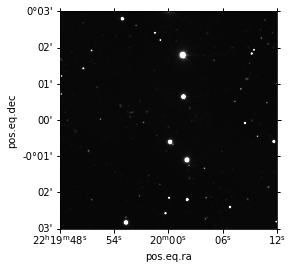

In [10]:
print(image.min(),image.max(),image.shape)
ax = plt.subplot(projection=wcs)
ax.imshow(image,cmap='gray',vmin=image.min(),vmax=image.min()+(image.max()-image.min())/100.)
plt.show()

### Catalog overlay
We can also query the database for catalog objects and overlay them easily on the image cutout.  In this example, we query around the central position for objects in the NOIRLab Source Catalog DR2 object table:

In [11]:
sql = '''SELECT ra, dec, gmag 
            FROM nsc_dr2.object 
            WHERE Q3C_RADIAL_QUERY(ra,dec,{0},{1},{2})
            AND gerr < 0.1 AND gmag < 22
'''.format(ra, dec, fov/2)
df = qc.query(sql=sql, fmt='pandas')

Here we'll use the object *g*-band magnitudes to control the sizes of the markers.

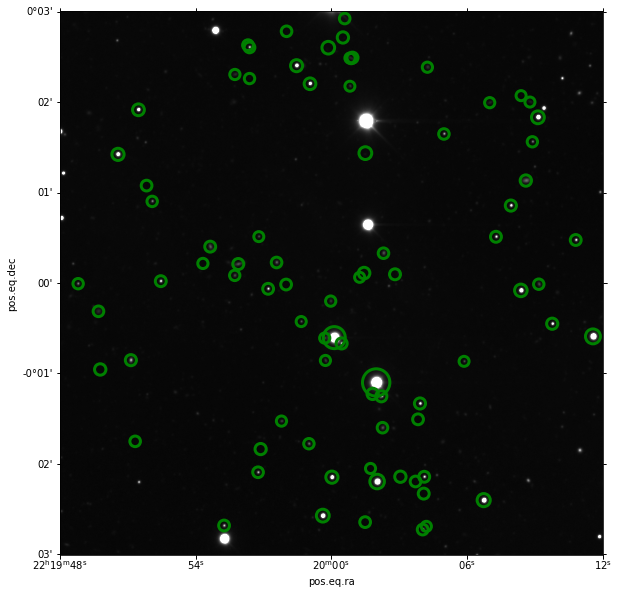

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=wcs)
ax.imshow(image, cmap='gray', vmin=image.min(), vmax=image.min()+(image.max()-image.min())/100.)
ax.scatter(df['ra'], df['dec'], transform=ax.get_transform('icrs'), s=1000./(df['gmag']-12), 
           edgecolor='green', facecolor='none', linewidths=3)
plt.show()

## Save image to VOSpace
If you're not intending to display or work with the image in the notebook, but instead want to save the image as a file, the storeClient can copy the cutout URL directly to VOSpace.

First we'll check that we're logged in:

In [13]:
ac.whoAmI() # if result is 'anonymous', you'll need to login with ac.login()

'demo00'

Then save the contents of the image cutout URL to VOSpace:

In [14]:
sc.load('cutout.fits',url)

'OK'

In [15]:
print(sc.ls('cutout.fits',format='long'))

-rw-rw-r-x  demo00  19153002  27 Dec 2021 18:32  cutout.fits



<a class="anchor" id="chapter3"></a>
# Making the process easier with functions
The example workflow above lends itself to writing s short function to access the SIA service, filter the metadata table to narrow down the search result, and retrieve the cutout.  Here we write a function to get the deepest stacked image for a given image collection and band, and another function to plot the images.

In [16]:
# A little function to download the deepest stacked images
#   adapted from R. Nikutta
def download_deepest_image(ra,dec,svc=sia.SIAService('https://datalab.noirlab.edu/sia'),fov=0.1,band='g'):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
    
    sel0 = startswith(imgTable['obs_bandpass'].astype(str),band)
    print("The full image list contains", len(imgTable[sel0]), "entries with bandpass="+band)

    sel = sel0 & ((imgTable['proctype'] == 'Stack') & (imgTable['prodtype'] == 'image')) # basic selection
    Table = imgTable[sel] # select
    if (len(Table)>0):
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print ('downloading deepest ' + band + ' image...')
        image = fits.getdata(download_file(url,cache=True,show_progress=False,timeout=120))

    else:
        print ('No image available.')
        image=None
        
    return image

In [17]:
# Multi panel image plotter
def plot_images(images,geo=None,panelsize=4,bands=list('gri'),cmap=matplotlib.cm.gray_r):
    n = len(images)
    if geo is None: geo = (n,1)
        
    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        if img is not None:
            print(img.min(),img.max())
            vmin = np.median(img)-2*np.std(img)
            vmax = np.median(img)+2*np.std(img)
            ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,vmin=vmin, vmax=vmax)
            ax.set_title('%s band' % bands[j])
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

We run the function to get cutouts from deep stack in g, r, and i bands.

In [18]:
band = 'g'
gimage = download_deepest_image(ra, dec, svc=svc, fov=0.1, band=band) # FOV in deg
band = 'r'
rimage = download_deepest_image(ra, dec, svc=svc, fov=0.1, band=band) # FOV in deg
band = 'i'
iimage = download_deepest_image(ra, dec, svc=svc, fov=0.1, band=band) # FOV in deg
images=[gimage,rimage,iimage]

The full image list contains 533 entries with bandpass=g
downloading deepest g image...
The full image list contains 523 entries with bandpass=r
downloading deepest r image...
The full image list contains 350 entries with bandpass=i
downloading deepest i image...


Now we plot the image per band and make a 3-color image from the output.

118.10046 19471.238
360.86533 38469.46
981.00226 35315.805


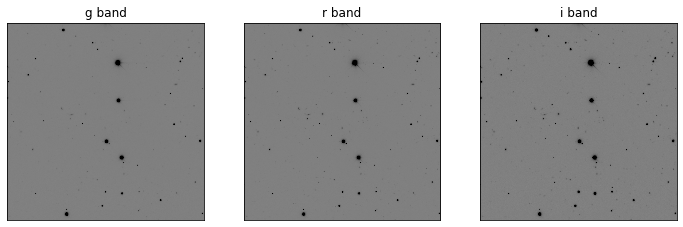

In [19]:
gimage2 = gimage-np.median(gimage)
rimage2 = rimage-np.median(rimage)
iimage2 = iimage-np.median(iimage)
img = make_lupton_rgb(iimage2, rimage2, gimage2, Q=10, stretch=30)
plot_images(images)

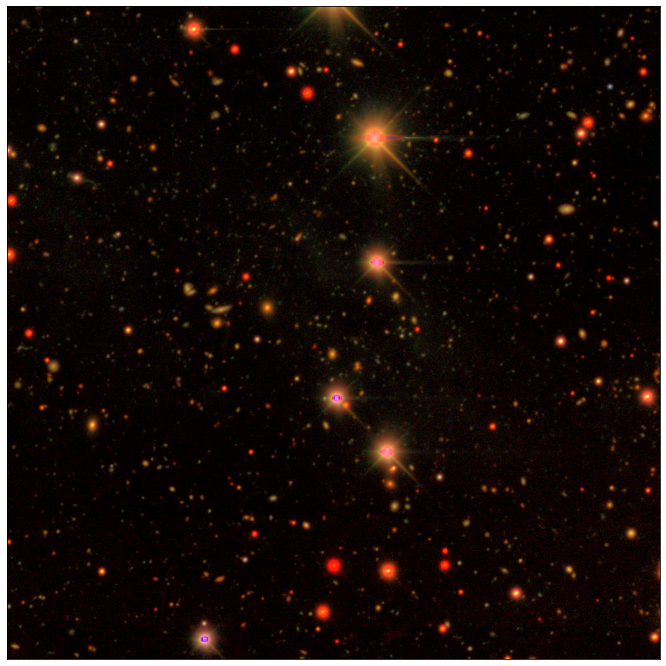

In [20]:
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(1,1,1)

ax.imshow(img,origin='lower')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)